In [ ]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, median_absolute_error
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import numpy as np
from scipy import stats
import plotly.express as px

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
df=pd.read_csv("/content/Superstore Sales.csv",encoding='windows-1252')

In [ ]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/08/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/08/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,06/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [ ]:
df.dtypes

,0
Row ID,int64
Order ID,object
Order Date,object
Ship Date,object
Ship Mode,object
Customer ID,object
Customer Name,object
Segment,object
Country,object
City,object


In [ ]:
df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [ ]:
df.isnull().sum()

,0
Row ID,0
Order ID,0
Order Date,0
Ship Date,0
Ship Mode,0
Customer ID,0
Customer Name,0
Segment,0
Country,0
City,0


In [ ]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

In [ ]:
df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month
df['Order Day of Week'] = df['Order Date'].dt.dayofweek

In [ ]:
df.dtypes

,0
Row ID,int64
Order ID,object
Order Date,datetime64[ns]
Ship Date,datetime64[ns]
Ship Mode,object
Customer ID,object
Customer Name,object
Segment,object
Country,object
City,object


In [ ]:
# Select numeric columns
df_numeric = df.select_dtypes(include=[np.number])

for col in df_numeric.columns:
    # Calculate z-score of the column
    z_score = np.abs(stats.zscore(df[col]))
    outliers_num = len(np.where(z_score > 3)[0])
    if outliers_num:
        print('{}: {}'.format(col, outliers_num))

Sales: 127
Quantity: 113
Discount: 300
Profit: 107


In [ ]:
data_numeric = df_numeric.drop(['Quantity', 'Discount'], axis=1)

z_scores = np.abs(stats.zscore(df_numeric))

# Save old DataFrame
old_df = df.copy()

# DataFrame without outliers
df = df[(z_scores < 3).all(axis=1)]
df.shape

(9436, 24)

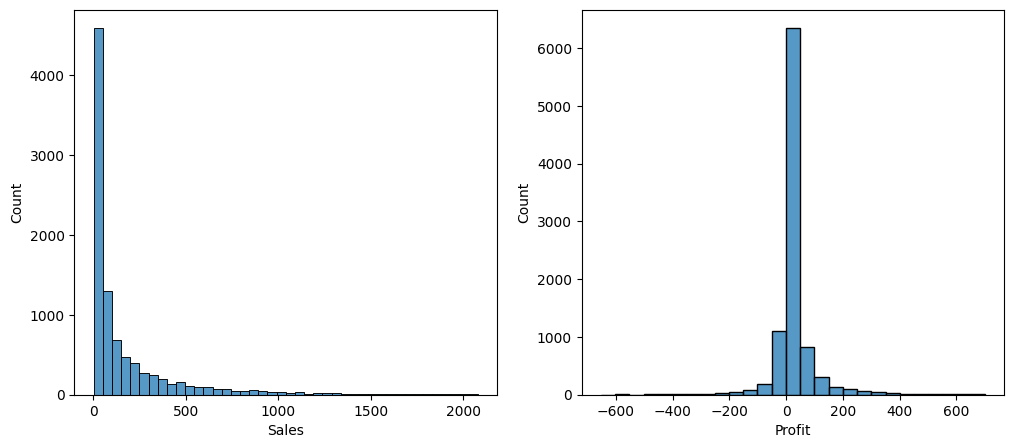

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(x=df['Sales'], ax=ax[0], binwidth=50)
sns.histplot(x=df['Profit'], ax=ax[1], binwidth=50);

In [ ]:
df["Lead time"] = (df["Ship Date"]-df["Order Date"]).dt.days

In [ ]:
df["year"]=df.loc[:,"Order Date"].dt.year
df['year_month'] = df['Order Date'].dt.strftime('%Y-%m')

In [ ]:
df

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sales,Quantity,Discount,Profit,Order Year,Order Month,Order Day of Week,Lead time,year,year_month
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,261.9600,2,0.00,41.9136,2016,11,1,3,2016,2016-11
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,731.9400,3,0.00,219.5820,2016,11,1,3,2016,2016-11
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,14.6200,2,0.00,6.8714,2016,6,6,4,2016,2016-06
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,957.5775,5,0.45,-383.0310,2015,10,6,7,2015,2015-10
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,22.3680,2,0.20,2.5164,2015,10,6,7,2015,2015-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,CA-2014-110422,2014-01-21,2014-01-23,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,25.2480,3,0.20,4.1028,2014,1,1,2,2014,2014-01
9990,9991,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,91.9600,2,0.00,15.6332,2017,2,6,5,2017,2017-02
9991,9992,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,258.5760,2,0.20,19.3932,2017,2,6,5,2017,2017-02
9992,9993,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,29.6000,4,0.00,13.3200,2017,2,6,5,2017,2017-02


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9436 entries, 0 to 9993
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Row ID             9436 non-null   int64         
 1   Order ID           9436 non-null   object        
 2   Order Date         9436 non-null   datetime64[ns]
 3   Ship Date          9436 non-null   datetime64[ns]
 4   Ship Mode          9436 non-null   object        
 5   Customer ID        9436 non-null   object        
 6   Customer Name      9436 non-null   object        
 7   Segment            9436 non-null   object        
 8   Country            9436 non-null   object        
 9   City               9436 non-null   object        
 10  State              9436 non-null   object        
 11  Postal Code        9436 non-null   int64         
 12  Region             9436 non-null   object        
 13  Product ID         9436 non-null   object        
 14  Category     

In [ ]:
print(f"Number of Unique Orders is {df['Order ID'].nunique()}")

Number of Unique Orders is 4858


In [ ]:
print(f"Number of categories is {df['Category'].nunique()} and sub-categories is {df['Sub-Category'].nunique()}")

Number of categories is 3 and sub-categories is 17


In [ ]:
df_regions = df.groupby("Region")[["Profit","Sales","Order ID","Lead time"]].agg({
    "Profit":"sum",
    "Sales":"sum",
    "Order ID": 'count',
    "Lead time": "mean"
}).reset_index()
df_regions.columns = ['Region', 'Profit', 'Sales','Number of Orders','Lead time']
df_regions

,Region,Profit,Sales,Number of Orders,Lead time
0,Central,38655.0007,367217.6692,1981,4.048965
1,East,55306.2054,478187.1950,2769,3.899603
2,South,39596.0951,264746.8200,1567,3.955967
3,West,82630.6544,569645.6925,3119,3.936197


In [ ]:
fig = px.bar(df_regions,
             x='Region',
             y=['Profit', 'Sales'],
             title='Profit and sales by Region',
             labels={'value': 'Amount', 'Region': 'Region', 'variable': 'Metric'},
             barmode='group',
             height=600)

# Update layout for better readability
fig.update_layout(legend_title_text='Metric')

# Show the figure
fig.show()

In [ ]:
fig = px.pie(data_frame=df_regions,names="Region",values="Number of Orders",height=600,hole=0.4
             ,title="Number of Orders by Region")

fig.update_traces(textinfo='label+value+percent')

fig.show()

In [ ]:
states = df.groupby("State")[["Profit","Sales","Order ID"]].agg({'Profit':'sum','Sales':'sum','Order ID':'count'})\
.sort_values(by="Profit",ascending=False)\
.reset_index()[:10]

states.columns = ["State","Profit","Sales","Number of Orders"]
fig = px.bar(states,
            x= "State",
            y=["Profit","Sales"],
            title="Top 10 States in terms of profit and their sales",
            height=600,
            barmode="group")
fig.update_layout(legend_title_text='Metric')

fig.show()

In [ ]:
products = df.groupby("Product Name")[["Profit","Sales","Quantity"]].agg({'Profit':'sum','Sales':'sum','Quantity':'sum'})\
.sort_values(by="Profit",ascending=False)\
.reset_index()[:10]

In [ ]:
fig = px.bar(products,
             x='Product Name',
             y=['Profit', 'Sales'],
             title='Top 10 Products in terms of profit',
             labels={'value': 'Amount', 'Region': 'Region', 'variable': 'Metric'},
             barmode='group',
             height=1000)

# Update layout for better readability
fig.update_layout(legend_title_text='Metric')

# Show the figure
fig.show()

<ipython-input-25-bb32ffef7f84>:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Axes: xlabel='Ship Mode', ylabel='count'>

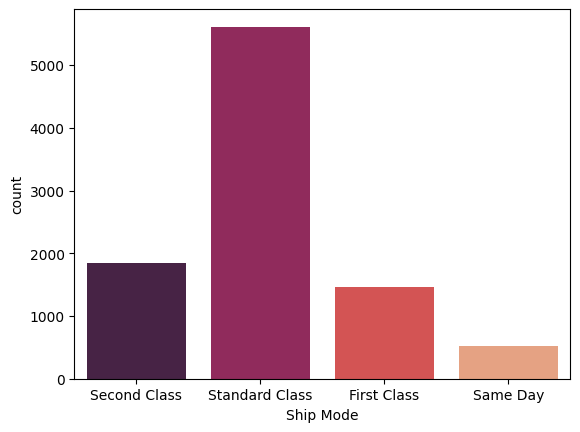

In [ ]:
sns.countplot(x=df['Ship Mode'],palette='rocket')

In [ ]:
corr=df[['Discount','Sales','Profit', 'Quantity','Ship Date']].corr()
corr.style.background_gradient(cmap='coolwarm')
print("correlation Matrix: \n",corr)

correlation Matrix: 
            Discount     Sales    Profit  Quantity  Ship Date
Discount   1.000000 -0.010596 -0.359596  0.003517  -0.000050
Sales     -0.010596  1.000000  0.449825  0.253133  -0.018167
Profit    -0.359596  0.449825  1.000000  0.119362  -0.000252
Quantity   0.003517  0.253133  0.119362  1.000000   0.001857
Ship Date -0.000050 -0.018167 -0.000252  0.001857   1.000000


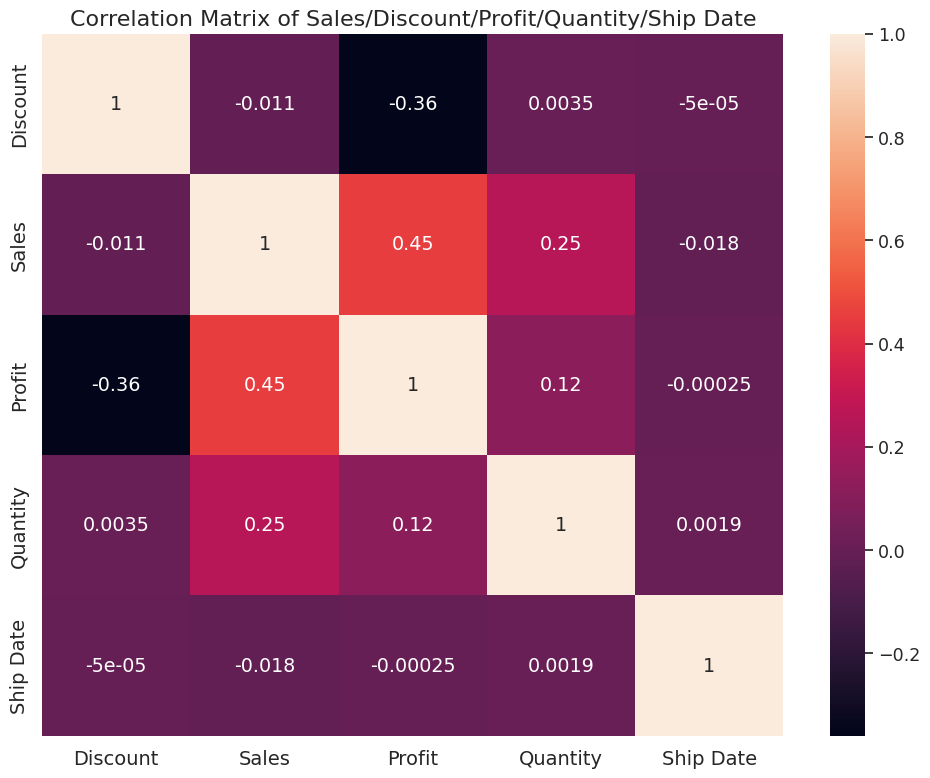

In [ ]:
sns.set(font_scale=1.15)
plt.figure(figsize=(10,8))
plt.title("Correlation Matrix of Sales/Discount/Profit/Quantity/Ship Date", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.heatmap(corr, annot=True)
plt.tight_layout()
plt.show()

In [ ]:
def scatter_plot(df, var1, var2, label):
    sns.set(font_scale=1.5)
    plt.figure(figsize=(10,8))
    plt.title(label, fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    sns.regplot(x=df[var1],y=df[var2],  fit_reg=False)
    plt.tight_layout()
    plt.show()

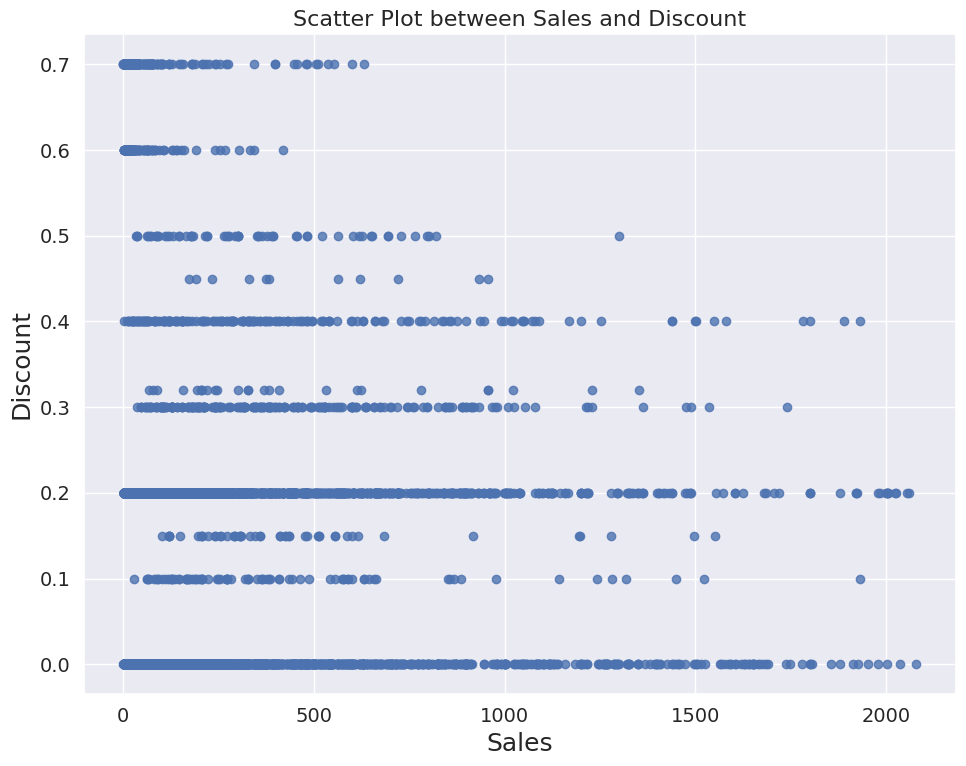

In [ ]:
scatter_plot(df, 'Sales', 'Discount', "Scatter Plot between Sales and Discount")

<ipython-input-31-e5487571eb6f>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




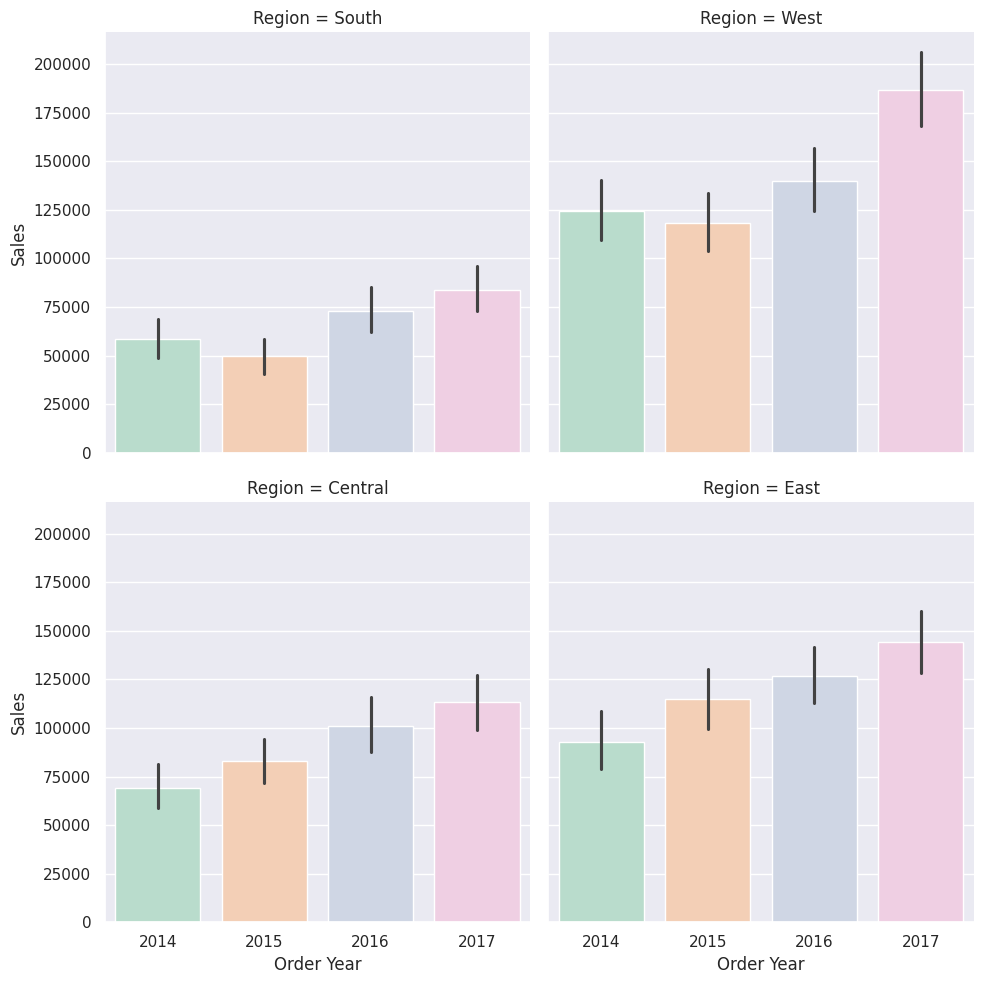

In [ ]:
sns.set(rc={"figure.figsize":(20, 20)}) #width=3, #height=4
g=sns.catplot(x="Order Year", y="Sales",col="Region",col_wrap=2, data=df, kind="bar",height=5, aspect=1, estimator=sum,palette="Pastel2")

In [ ]:
metric_over_time = df.groupby('year_month')[['Profit','Sales']].mean().reset_index()

# Convert 'year_month' to datetime for proper ordering
metric_over_time['date'] = pd.to_datetime(metric_over_time['year_month'] + '-01')

# Sort the data by date
metric_over_time = metric_over_time.sort_values('date')

# Create the line chart
fig = px.line(metric_over_time,
              x='date',
              y=['Profit','Sales'],
              title='Average Profit and sales by Month and Year',
              labels={'date': 'Date', 'Profit': 'Average Profit'},
             markers=True,
             height=600)

# Customize the x-axis to show both year and month
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y"
)
fig.update_layout(legend_title_text='Metric')

# Show the plot
fig.show()

In [ ]:
df_time=pd.read_csv("/content/Superstore Sales.csv", encoding='cp1252',index_col='Order Date',parse_dates=True)
df_time=df_time.rename_axis('Date')
df_holiday=pd.read_csv("/content/US Holiday Dates (2004-2021).csv",index_col='Date',parse_dates=True)

In [ ]:
df_holiday.head()

,Holiday,WeekDay,Month,Day,Year
Date,,,,,
2004-07-04,4th of July,Sunday,7,4,2004
2005-07-04,4th of July,Monday,7,4,2005
2006-07-04,4th of July,Tuesday,7,4,2006
2007-07-04,4th of July,Wednesday,7,4,2007
2008-07-04,4th of July,Friday,7,4,2008


In [ ]:
df_merged=pd.merge(df_time,df_holiday,on='Date',how='left',suffixes=('_store','_holl'))

In [ ]:
df_merged.head(3)

,Row ID,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,...,Product Name,Sales,Quantity,Discount,Profit,Holiday,WeekDay,Month,Day,Year
Date,,,,,,,,,,,,,,,,,,,,,
2016-11-08,1,CA-2016-152156,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,...,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136,NaN,NaN,NaN,NaN,NaN
2016-11-08,2,CA-2016-152156,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,...,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820,NaN,NaN,NaN,NaN,NaN
2016-06-12,3,CA-2016-138688,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,...,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_merged['Holiday']=df_merged['Holiday'].fillna('no-vacation')

In [ ]:
df_merged['Holiday'].unique()

array(['no-vacation', 'Veterans Day', 'Thanksgiving Eve',
       'Thanksgiving Day', 'Christmas Day', 'Western Easter', 'Labor Day',
       'Columbus Day', 'Christmas Eve', 'Memorial Day',
       'Labor Day Weekend', 'Juneteenth', "Washington's Birthday",
       "New Year's Day", 'Martin Luther King, Jr. Day', 'New Year’s Eve',
       '4th of July', 'Eastern Easter', 'Valentine’s Day'], dtype=object)

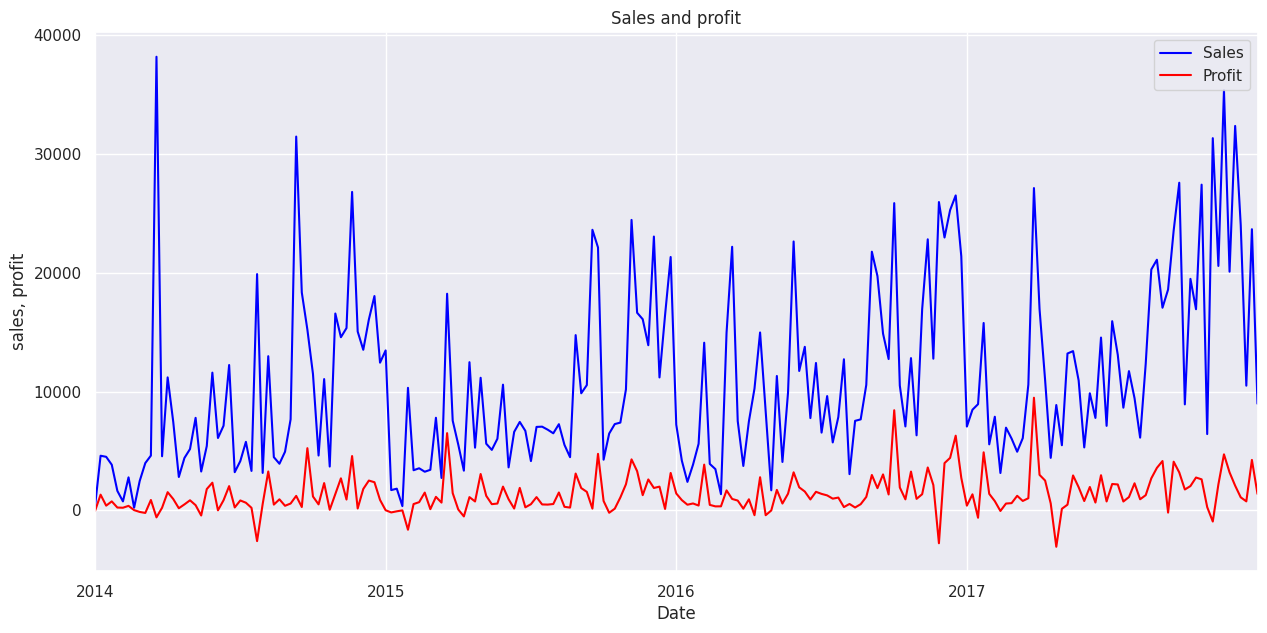

In [ ]:
plt.figure(figsize=(15,7))
df_time['Sales'].resample('W').sum().plot(color='blue')
df_time['Profit'].resample('W').sum().plot(color='red')
plt.title("Sales and profit")
plt.xlabel("Date")
plt.ylabel("sales, profit")
plt.legend(['Sales','Profit'])
plt.show()

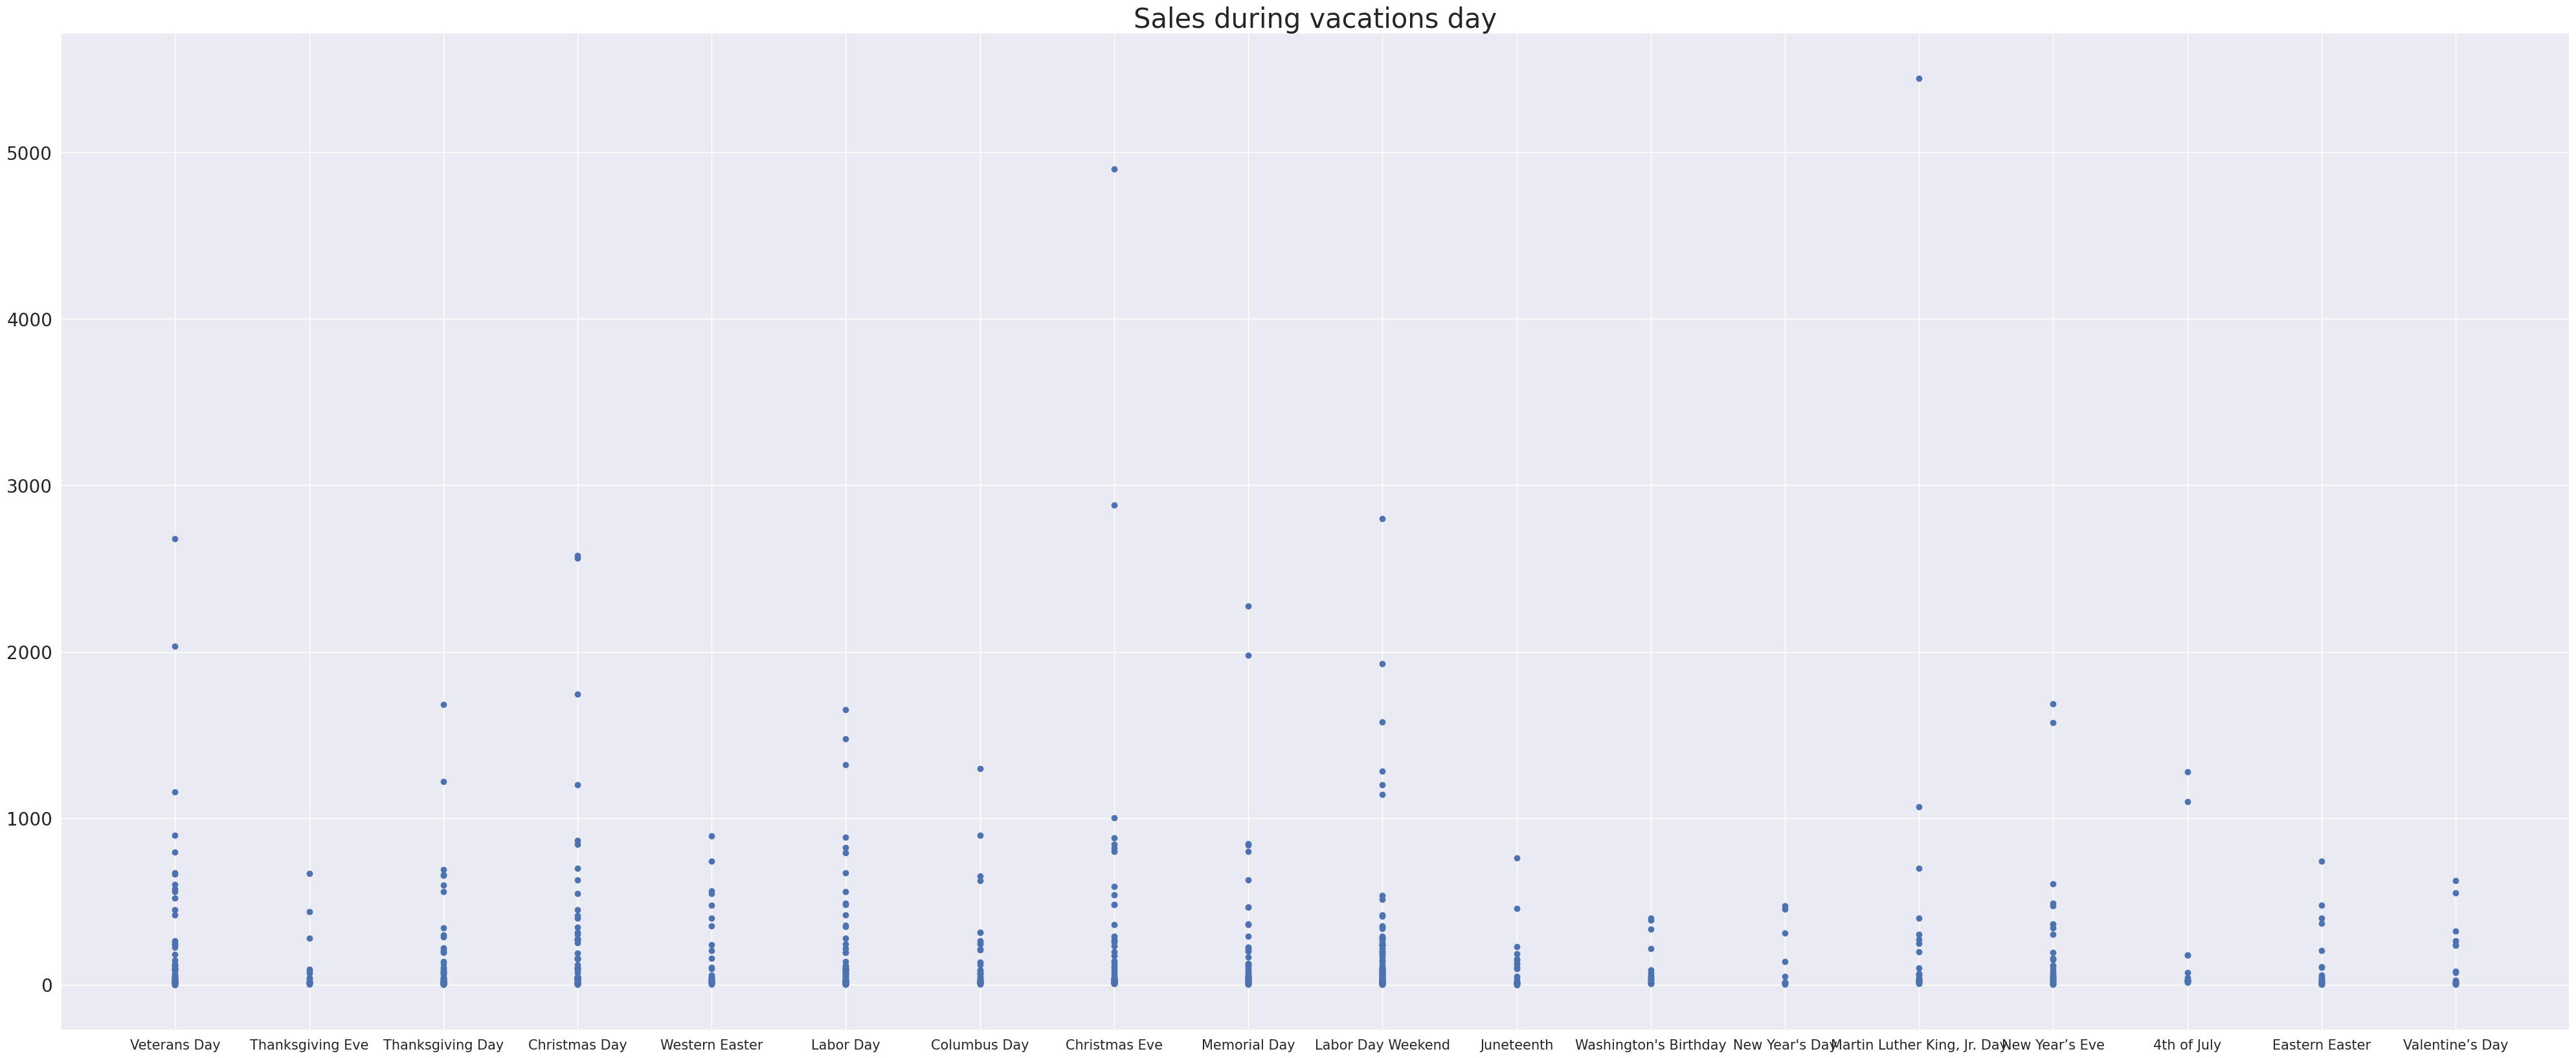

In [ ]:
plt.figure(figsize=(50,20))
plt.title('Sales during vacations day',size=30)
plt.yticks(size=20)
plt.xticks(size=15)
plt.scatter(df_merged[df_merged['Holiday']!='no-vacation']['Holiday'],df_merged[df_merged['Holiday']!='no-vacation']['Sales'])
plt.show()

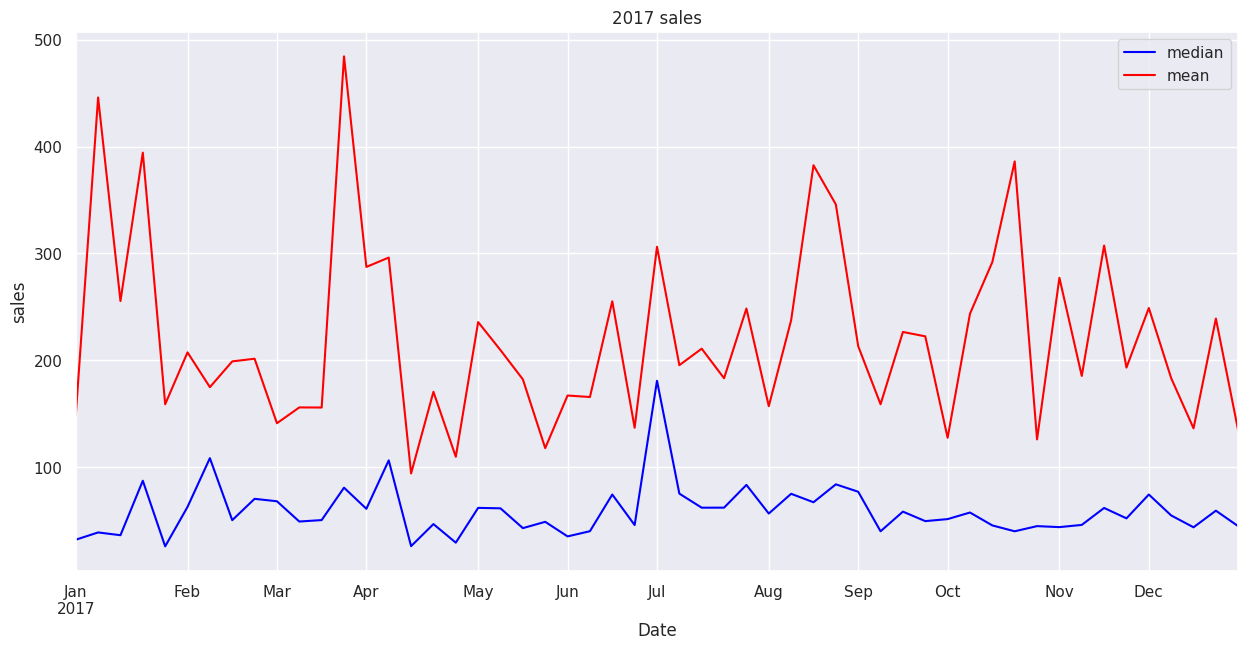

In [ ]:
plt.figure(figsize=(15,7))
plt.title("2017 sales")
plt.xlabel("Date")
plt.ylabel("sales")
df_time.loc['2017']['Sales'].resample('W').median().plot(style='-',color='blue')
df_time.loc['2017']['Sales'].resample('W').mean().plot(style='-',color='red')
plt.legend(['median','mean'])
plt.show()

In [ ]:
import statsmodels.api as sm

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [ ]:
## create a ARIMA model
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
from datetime import datetime,timedelta
train_dataset_end=datetime(1955,12,1)
test_dataset_end=datetime(1960,12,1)

In [ ]:
##prediction
pred_start_date=df.index[0]
pred_end_date=df.index[-1]

<Figure size 2000x700 with 0 Axes>

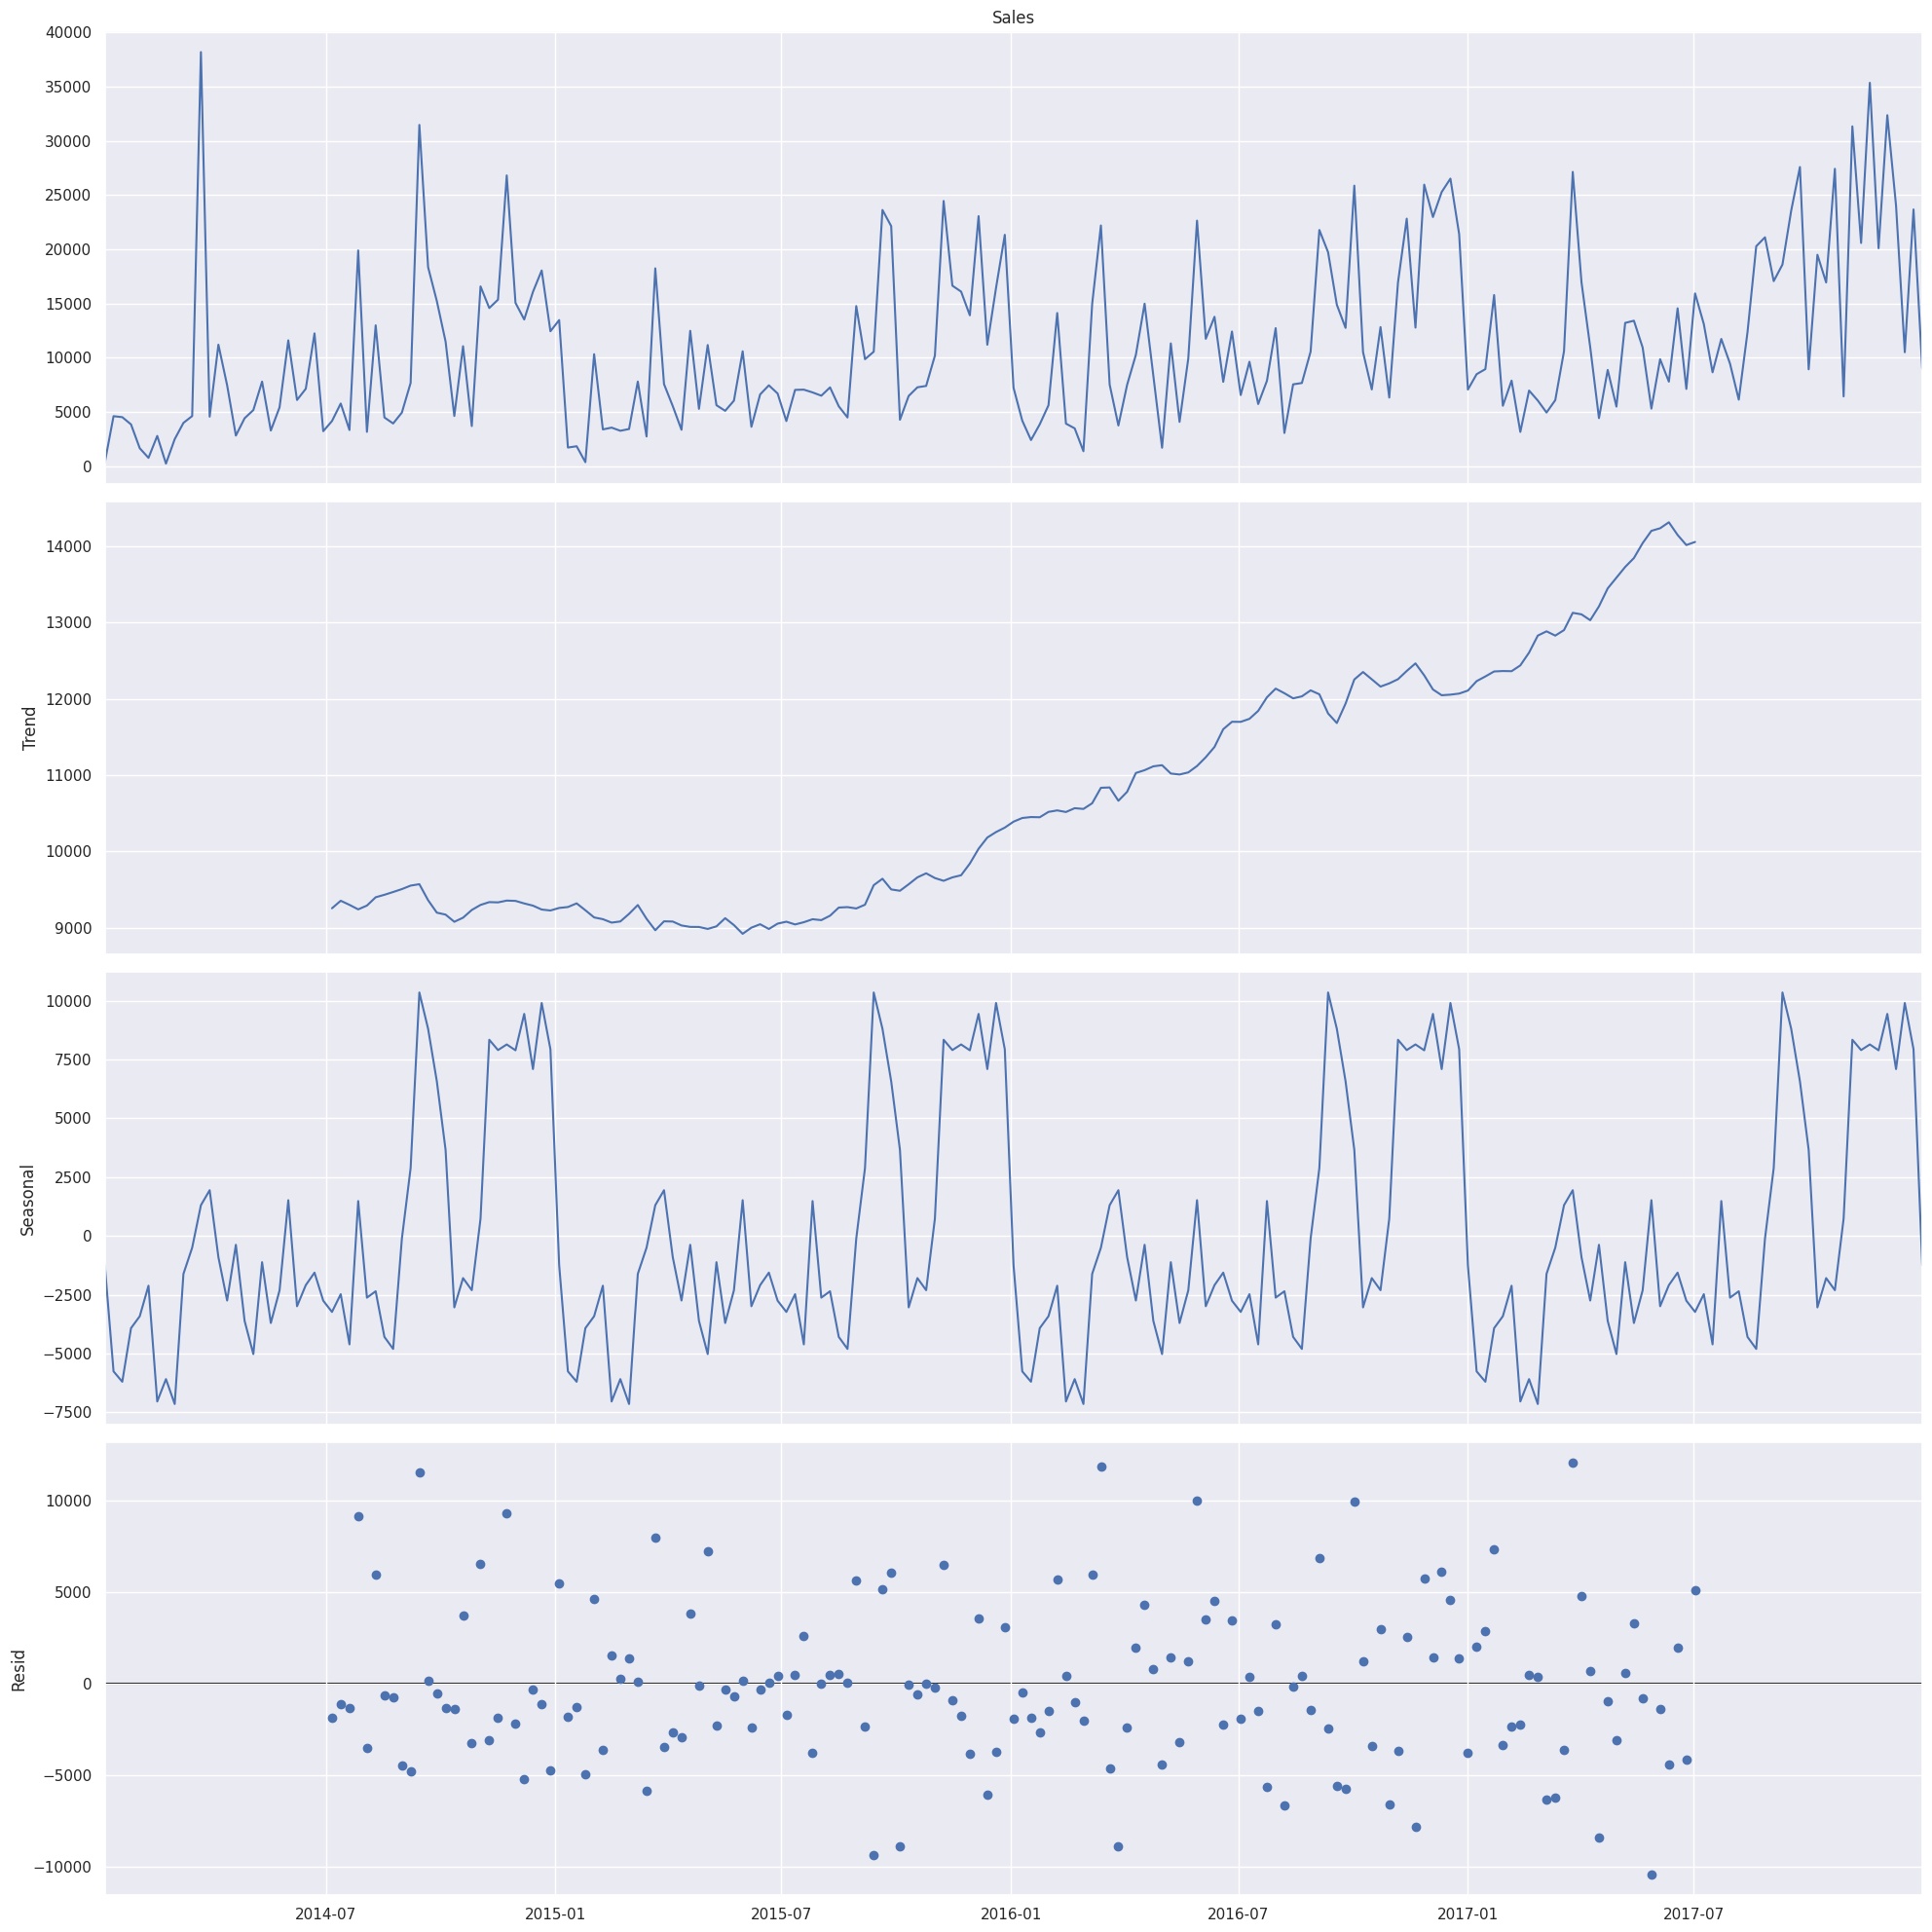

In [ ]:
decomposition=sm.tsa.seasonal_decompose(df_time['Sales'].resample('W').sum(),model='additive')

figure=plt.figure(figsize=(20,7))
decomposition.plot()
plt.show()

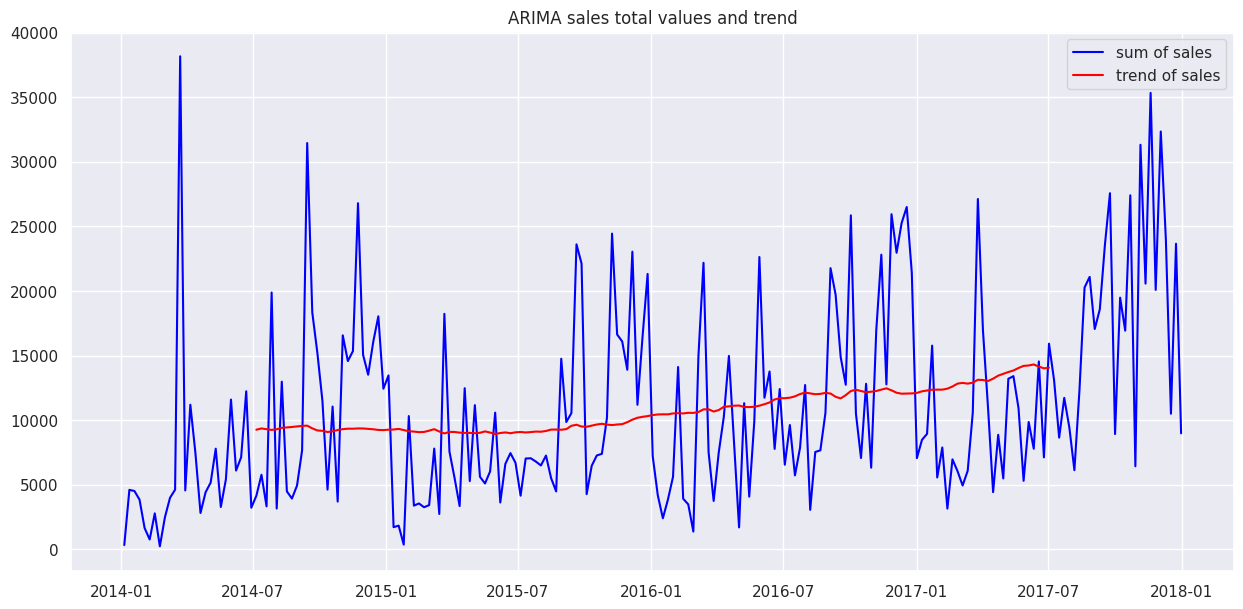

In [ ]:
figtrend=plt.figure(figsize=(15,7))
plt.title("ARIMA sales total values and trend")
plt.plot(df_time['Sales'].resample('W').sum(),c='blue')
plt.plot(decomposition.trend.index, decomposition.trend, c='red')
plt.legend(["sum of sales","trend of sales"])
plt.show()

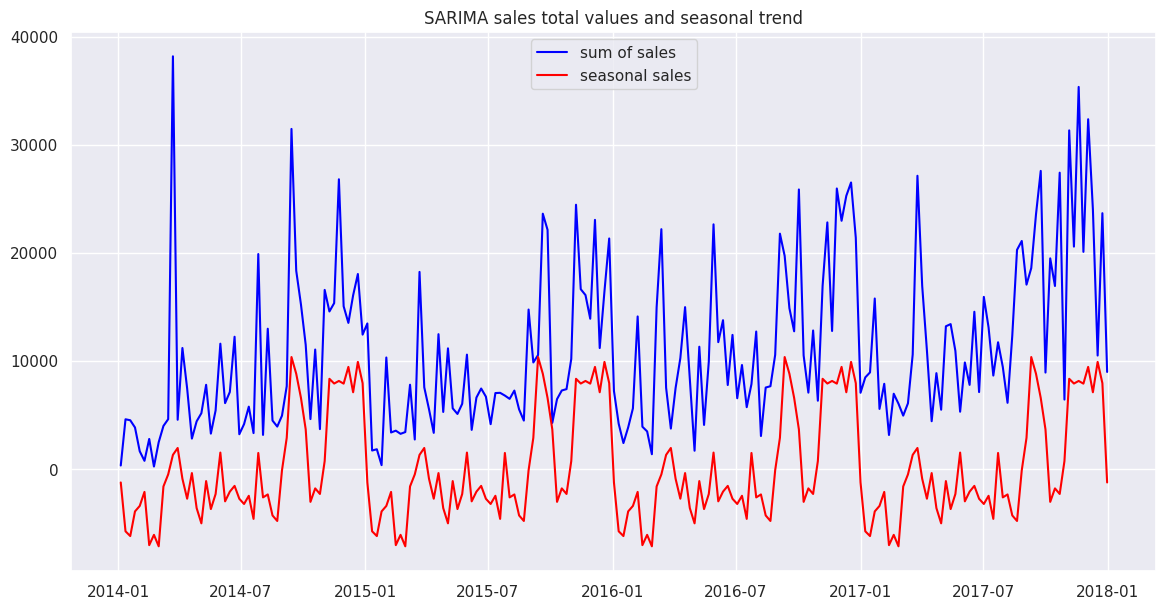

In [ ]:
figseason=plt.figure(figsize=(14,7))
plt.title("SARIMA sales total values and seasonal trend")
plt.plot(df_time['Sales'].resample('W').sum(),c='blue')
plt.plot(decomposition.seasonal.index, decomposition.seasonal, c='red')
plt.legend(["sum of sales","seasonal sales"])
plt.show()

In [ ]:
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



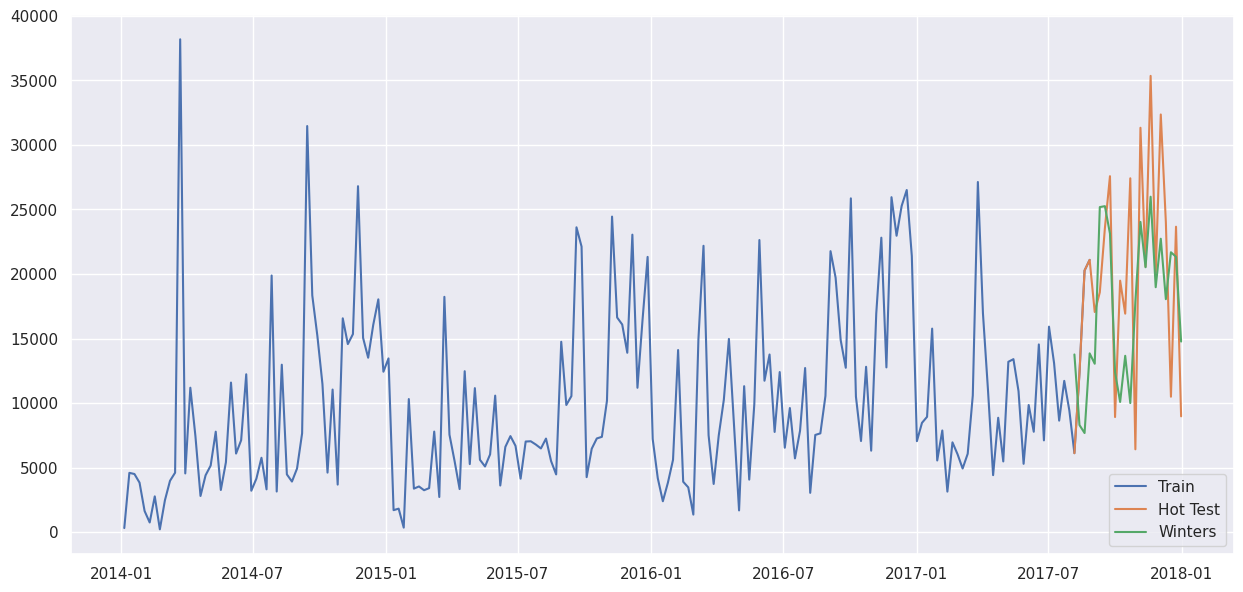

In [ ]:
X=df_time['Sales'].resample('W').sum()

train=X['2014-01-05':'2017-08']
test=X['2017-08':]

model = ExponentialSmoothing(train, trend='add',seasonal='add').fit()
pred = model.predict(start=test.index[0], end=test.index[-1])

predfig=plt.figure(figsize=(15,7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Hot Test')
plt.plot(pred.index, pred, label='Winters')
plt.legend(loc='best')
plt.show()

In [ ]:
X = df.drop("Profit",axis=1)
Y = df["Sales"]

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)

In [ ]:
def RSE(Y_true, Y_predicted):
    Y_true = np.array(y_true)
    Y_predicted = np.array(Y_predicted)
    RSS = np.sum(np.square(Y_true - Y_predicted))

    rse = sqrt(RSS / (len(Y_true) - 2))
    return rse

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from __future__ import unicode_literals
from imblearn.combine import SMOTETomek
from math import *
from sklearn.model_selection import cross_validate,cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBRegressor,XGBClassifier
from lightgbm import LGBMClassifier,LGBMRegressor
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score,precision_score
from holidays import CountryHoliday
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV,LogisticRegression,ElasticNet
from sklearn.ensemble import BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.ensemble import BaggingClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import classification_report, f1_score,accuracy_score ,confusion_matrix
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import IsolationForest
import matplotlib.gridspec as gridspec
from sklearn.impute import KNNImputer
import seaborn as sns
import warnings
from warnings import simplefilter
import ast
simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [ ]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit', 'Order Year',
       'Order Month', 'Order Day of Week', 'Lead time', 'year', 'year_month'],
      dtype='object')

In [ ]:
#encoding of categorial features
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in df.columns:
    if(df.dtypes[i] == 'object'):
        df[i] = le.fit_transform(df[i])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9436 entries, 0 to 9993
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Order Date         9436 non-null   datetime64[ns]
 1   Segment            9436 non-null   int64         
 2   City               9436 non-null   int64         
 3   State              9436 non-null   int64         
 4   Category           9436 non-null   int64         
 5   Sub-Category       9436 non-null   int64         
 6   Sales              9436 non-null   float64       
 7   Quantity           9436 non-null   int64         
 8   Discount           9436 non-null   float64       
 9   Profit             9436 non-null   float64       
 10  Order Year         9436 non-null   int32         
 11  Order Month        9436 non-null   int32         
 12  Order Day of Week  9436 non-null   int32         
 13  Lead time          9436 non-null   int64         
 14  year         

In [ ]:

X = df.drop(["Profit"], axis = 1)
y = df["Profit"]

# Check the final size of groups for testing and training
print("X shape : ", X.shape)
print("y shape : ", y.shape)

X shape :  (9436, 15)
y shape :  (9436,)


In [ ]:
# Divide the data into training group (70%) and test group (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# View the final size of the groups
x_train_shape = X_train.shape
x_test_shape = X_test.shape

print("X_train shape = {}\nX_test shape = {}".format(x_train_shape, x_test_shape))

X_train shape = (6605, 15)
X_test shape = (2831, 15)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Define the model
model_RandomForestRegressor = RandomForestRegressor()
model_RandomForestRegressor.fit(X_train, y_train)

# Training
pred_train_RandomForestRegressor = model_RandomForestRegressor.predict(X_train)

# Test
pred_test_RandomForestRegressor = model_RandomForestRegressor.predict(X_test)

# Calculate regression model performance metrics for training data
r2_train_RandomForestRegressor = r2_score(y_train, pred_train_RandomForestRegressor)
mse_train_RandomForestRegressor = mean_squared_error(y_train, pred_train_RandomForestRegressor)
rmse_train_RandomForestRegressor = np.sqrt(mean_squared_error(y_train, pred_train_RandomForestRegressor))
mae_train_RandomForestRegressor = mean_absolute_error(y_train, pred_train_RandomForestRegressor)

# Calculate regression model performance metrics for the test data
r2_test_RandomForestRegressor = r2_score(y_test, pred_test_RandomForestRegressor)
mse_test_RandomForestRegressor = mean_squared_error(y_test, pred_test_RandomForestRegressor)
rmse_test_RandomForestRegressor = np.sqrt(mean_squared_error(y_test, pred_test_RandomForestRegressor))
mae_test_RandomForestRegressor = mean_absolute_error(y_test, pred_test_RandomForestRegressor)

# Print regression metrics
print("\033[1mMETRICS FOR TRAINING DATA:\033[0m")
print("Random Forest Regressor R2 for training data is:", r2_train_RandomForestRegressor)
print("Random Forest Regressor Mean Squared Error [MSE] for training data is:", mse_train_RandomForestRegressor)
print("Random Forest Regressor Root Mean Squared Error [RMSE] for training data is:", rmse_train_RandomForestRegressor)
print("Random Forest Regressor Mean Absolute Error [MAE] for training data is:", mae_train_RandomForestRegressor)

print("\n\033[1mMETRICS FOR TEST DATA:\033[0m")
print("Random Forest Regressor R2 for test data is:", r2_test_RandomForestRegressor)
print("Random Forest Regressor Mean Squared Error [MSE] for test data is:", mse_test_RandomForestRegressor)
print("Random Forest Regressor Root Mean Squared Error [RMSE] for test data is:", rmse_test_RandomForestRegressor)
print("Random Forest Regressor Mean Absolute Error [MAE] for test data is:", mae_test_RandomForestRegressor)

METRICS FOR TRAINING DATA:
Random Forest Regressor R2 for training data is: 0.9748981643914826
Random Forest Regressor Mean Squared Error [MSE] for training data is: 154.94434861948264
Random Forest Regressor Root Mean Squared Error [RMSE] for training data is: 12.44766438411169
Random Forest Regressor Mean Absolute Error [MAE] for training data is: 4.566747818761381

METRICS FOR TEST DATA:
Random Forest Regressor R2 for test data is: 0.8697281724660908
Random Forest Regressor Mean Squared Error [MSE] for test data is: 951.2918880143988
Random Forest Regressor Root Mean Squared Error [RMSE] for test data is: 30.843020085821667
Random Forest Regressor Mean Absolute Error [MAE] for test data is: 12.201177943321772


In [ ]:
from sklearn.ensemble import AdaBoostRegressor

#Define the model
model_AdaBoostRegressor = AdaBoostRegressor()
model_AdaBoostRegressor.fit(X_train, y_train)

#Training
pred_train_AdaBoostRegressor = model_AdaBoostRegressor.predict(X_train)


#Test
pred_test_AdaBoostRegressor = model_AdaBoostRegressor.predict(X_test)

# Calculate regression model performance metrics for training data
r2_train_AdaBoostRegressor = r2_score(y_train, pred_train_AdaBoostRegressor)
mse_train_AdaBoostRegressor = mean_squared_error(y_train, pred_train_AdaBoostRegressor)
rmse_train_AdaBoostRegressor = np.sqrt(mean_squared_error(y_train, pred_train_AdaBoostRegressor))
mae_train_AdaBoostRegressor = mean_absolute_error(y_train, pred_train_AdaBoostRegressor)

#Calculate regression model performance metrics
r2_test_AdaBoostRegressor = r2_score(y_test, pred_test_AdaBoostRegressor)
mse_test_AdaBoostRegressor = mean_squared_error(y_test, pred_test_AdaBoostRegressor)
rmse_test_AdaBoostRegressor = np.sqrt(mean_squared_error(y_test, pred_test_AdaBoostRegressor))
mae_test_AdaBoostRegressor= mean_absolute_error(y_test, pred_test_AdaBoostRegressor)

# Print regression metrics for the training data
print("\033[1mMETRICS FOR TRAINING DATA:\033[0m")
print("Ada Boost Regressor R2 for training data is:", r2_train_AdaBoostRegressor)
print("Ada Boost Regressor Mean Squared Error [MSE] for training data is:", mse_train_AdaBoostRegressor)
print("Ada Boost Regressor Root Mean Squared Error [RMSE] for training data is:", rmse_train_AdaBoostRegressor)
print("Ada Boost Regressor Mean Absolute Error [MAE] for training data is:", mae_train_AdaBoostRegressor)

print("\n\033[1mMETRICS FOR TEST DATA:\033[0m")
print("Ada Boost Regressor R2 is:", r2_test_AdaBoostRegressor)
print("Ada Boost Regressor Mean Squared Error [MSE] is:", mse_test_AdaBoostRegressor)
print("Ada Boost Regressor Root Mean Squared Error [RMSE] is:", rmse_test_AdaBoostRegressor)
print("Ada Boost Regressor Mean Absolute Error [MAE] is:", mae_test_AdaBoostRegressor)

METRICS FOR TRAINING DATA:
Ada Boost Regressor R2 for training data is: 0.6367350274896744
Ada Boost Regressor Mean Squared Error [MSE] for training data is: 2242.300340887737
Ada Boost Regressor Root Mean Squared Error [RMSE] for training data is: 47.352933814999645
Ada Boost Regressor Mean Absolute Error [MAE] for training data is: 32.4044245782471

METRICS FOR TEST DATA:
Ada Boost Regressor R2 is: 0.6554564256796583
Ada Boost Regressor Mean Squared Error [MSE] is: 2515.9814944110785
Ada Boost Regressor Root Mean Squared Error [RMSE] is: 50.15956034906086
Ada Boost Regressor Mean Absolute Error [MAE] is: 33.24798154691139


In [ ]:
# Create a dataframe with the metrics of the tested models

models = pd.DataFrame({

     'Model': [
         'XGBRegressor', 'RandomForestRegressor',  'HistGradientBoostingRegressor',
         'AdaBoostRegressor'
     ],

     'R2 Score': [
         r2_test_xgb, r2_test_RandomForestRegressor, r2_test_HistGradientBoostingRegressor,
         r2_test_AdaBoostRegressor
     ],

     'MSE': [
         mse_test_xgb, mse_test_RandomForestRegressor,  mse_test_HistGradientBoostingRegressor,
         mse_test_AdaBoostRegressor
     ],

     'RMSE': [
         rmse_test_xgb, rmse_test_RandomForestRegressor,  rmse_test_HistGradientBoostingRegressor,
          rmse_test_AdaBoostRegressor
     ],

     'MAE': [
         mae_test_xgb, mae_test_RandomForestRegressor,  mae_test_HistGradientBoostingRegressor,
         mae_test_AdaBoostRegressor
     ]

})

In [ ]:

models_sorted = models.sort_values(by='R2 Score', ascending=False)
models_sorted

,Model,R2 Score,MSE,RMSE,MAE
1,RandomForestRegressor,0.869728,951.291888,30.843020,12.201178
2,HistGradientBoostingRegressor,0.856319,1049.212287,32.391547,13.569238
0,XGBRegressor,0.854970,1059.063986,32.543263,12.904630
3,AdaBoostRegressor,0.655456,2515.981494,50.159560,33.247982


In [ ]:
num_folds = 10

In [ ]:
# Initialize the  regression model
model = RandomForestRegressor()


In [ ]:
scores = cross_val_score(model, X, y, cv=num_folds, scoring='r2')

In [ ]:
for i, score in enumerate(scores):
     print(f"Fold {i+1}: {score}")

Fold 1: 0.8383644336558281
Fold 2: 0.8619096230472638
Fold 3: 0.762441476346172
Fold 4: 0.8836311156723067
Fold 5: 0.8825331195904591
Fold 6: 0.8541799653992699
Fold 7: 0.8509390702723371
Fold 8: 0.8629073649059118
Fold 9: 0.8496761829335465
Fold 10: 0.8515212901198421


In [ ]:
mean_score = scores.mean()
std_score = scores.std()

print(f"\nMean Score: {mean_score}")
print(f"Standard Deviation Score: {std_score}")


Mean Score: 0.8498103641942937
Standard Deviation Score: 0.0321250525254508


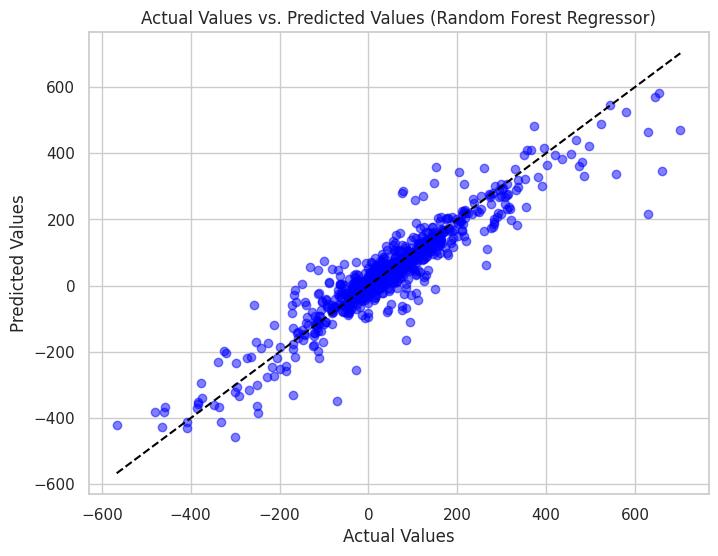

In [ ]:
# Create a DataFrame with actual and predicted values
df_results = pd.DataFrame({'Actual_Value': y_test, 'Predicted_Value': pred_test_RandomForestRegressor})

# View current and predicted values in a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_results['Actual_Value'], df_results['Predicted_Value'], color='blue', alpha=0.5)
plt.plot([df_results['Actual_Value'].min(), df_results['Actual_Value'].max()],
         [df_results['Actual_Value'].min(), df_results['Actual_Value'].max()],
         color='black', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual Values vs. Predicted Values (Random Forest Regressor)')
plt.grid(True)
plt.show()